# Fine-tuning Wav2Vec for TensorFlow Speech Recognition Challenge

This notebook demonstrates how to fine-tune a pre-trained Wav2Vec model for classifying speech commands from the TensorFlow Speech Recognition Challenge dataset.

## Setup and Dependencies

First, we'll install and import the necessary libraries.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Import libraries
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['TORCH_USE_CUDA_DSA'] = '1'  # Enable CUDA DSA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torchaudio
import soundfile as sf
from IPython.display import Audio
from pathlib import Path
from tqdm.notebook import tqdm

from transformers import Wav2Vec2ForSequenceClassification, Wav2Vec2FeatureExtractor
from transformers import TrainingArguments, Trainer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Import our custom dataset utility
import sys
sys.path.append('../utils')
from dataset_wav2vec import (
    SpeechCommandsWav2VecDataset,
    Wav2VecDataCollator,
    create_wav2vec_datasets
)

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")
if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory allocated: {torch.cuda.memory_allocated(0) / 1e9:.2f} GB")
    print(f"Memory cached: {torch.cuda.memory_reserved(0) / 1e9:.2f} GB")

Using device: cuda
GPU: NVIDIA GeForce GTX 1080
Memory allocated: 0.00 GB
Memory cached: 0.00 GB


## Explore the TensorFlow Speech Recognition Challenge Dataset

In [3]:
# Download the dataset if not already downloaded
# You can use the Kaggle API or download directly
# For this example, I'll assume you've already downloaded and extracted the dataset

# Define the dataset path (adjust this to your actual path)
dataset_path = '../../data/train/'
dataset_path = Path(dataset_path).resolve()

# Check if the dataset exists
if not os.path.exists(dataset_path):
    print("Dataset not found. Please download the TensorFlow Speech Recognition Challenge dataset.")
else:
    print("Dataset found.")

target_categories = [ 'yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'silence' ]
selected_categories = [ 'yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'silence', 'unknown' ]

Dataset found.


Found 32 categories: ['bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'four', 'go', 'happy', 'house', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'silence', 'six', 'stop', 'three', 'tree', 'two', 'up', 'wow', 'yes', 'zero', '_background_noise_']


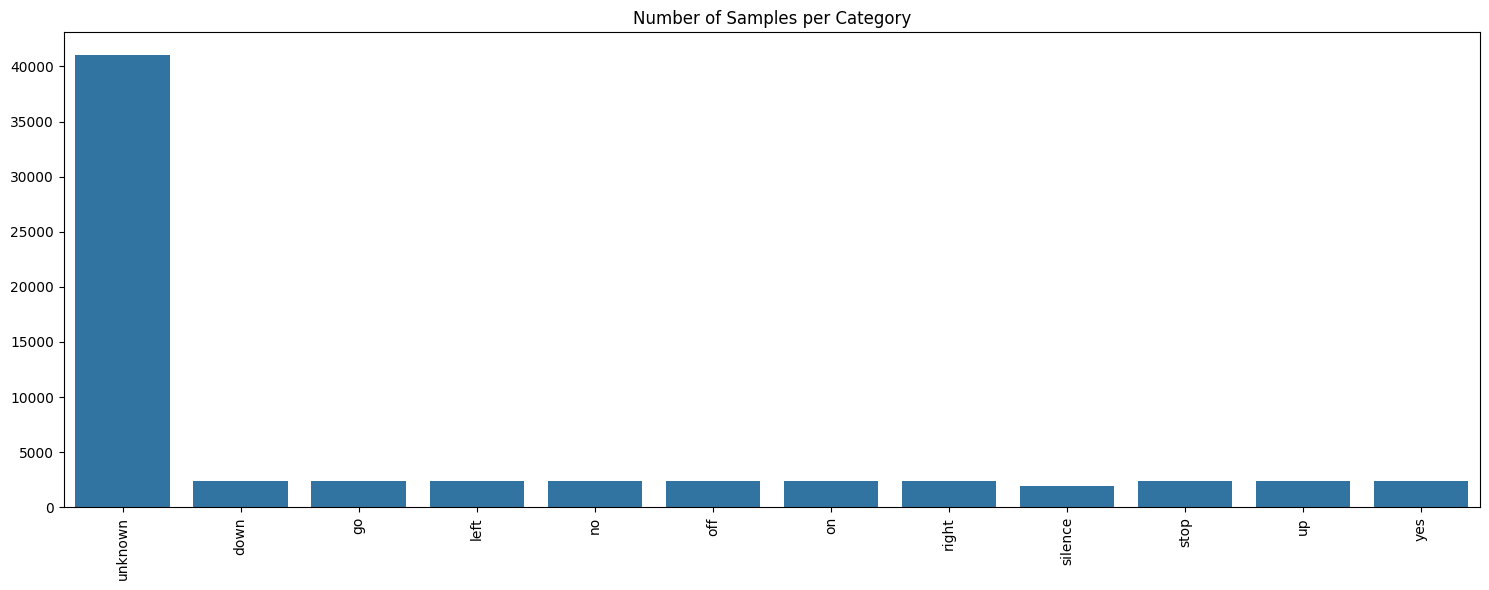

In [4]:
def explore_dataset(dataset_path):
    train_path = os.path.join(dataset_path, 'audio')
    categories_folders = os.listdir(train_path)
    print(f"Found {len(categories_folders)} categories: {categories_folders}")
    
    # Count samples in each category
    category_counts = {}
    for category in categories_folders:
        category_path = os.path.join(train_path, category)
        if category not in target_categories:
            category_counts['unknown'] = category_counts.get('unknown', 0) + len(os.listdir(category_path))
        else:
            if os.path.isdir(category_path):
                files = os.listdir(category_path)
                category_counts[category] = len(files)
    return categories_folders, category_counts

categories_folders, category_counts = explore_dataset(dataset_path)

# Visualize category distribution
plt.figure(figsize=(15, 6))
sns.barplot(x=list(category_counts.keys()), y=list(category_counts.values()))
plt.xticks(rotation=90)
plt.title('Number of Samples per Category')
plt.tight_layout()
plt.show()

## Prepare the Dataset

Let's prepare the dataset for training by loading the audio files and their labels.

In [5]:
dataset_path = dataset_path / 'audio'
all_data = {'training': [], 'validation': [], 'testing': []}

# Check if the directory exists
if not dataset_path.exists():
    raise FileNotFoundError(f"Dataset path does not exist: {dataset_path}")

print(f"Looking for audio files in: {dataset_path}")

Looking for audio files in: D:\Studia - Pobrane Wyklady\MINI\Semestr 8\Deep_Learning_Projects\Project_2\data\train\audio


In [20]:
# Define the paths to validation and testing lists
validation_list_path = os.path.join(dataset_path.parent, 'validation_list.txt')
testing_list_path = os.path.join(dataset_path.parent, 'testing_list.txt')

print(f"Validation list path: {validation_list_path}")
print(f"Testing list path: {testing_list_path}")

# Create datasets using our utility functions
train_dataset, val_dataset, test_dataset = create_wav2vec_datasets(
    dataset_path=dataset_path.parent,  # Parent directory containing 'audio' folder
    validation_list_path=validation_list_path,
    testing_list_path=testing_list_path,
    max_length=16000,  # 1 second at 16kHz
    sample_rate=16000
)

# Display information about our datasets
print(f"\nDataset Information:")
print(f"Training set: {len(train_dataset)} samples")
print(f"Validation set: {len(val_dataset)} samples")
print(f"Test set: {len(test_dataset)} samples")
print(f"Number of classes: {train_dataset.num_classes}")
print(f"Class mapping: {train_dataset.label_to_index}")

Validation list path: D:\Studia - Pobrane Wyklady\MINI\Semestr 8\Deep_Learning_Projects\Project_2\data\train\validation_list.txt
Testing list path: D:\Studia - Pobrane Wyklady\MINI\Semestr 8\Deep_Learning_Projects\Project_2\data\train\testing_list.txt
Validation files: 7094
Testing files: 7131
Looking for audio files in: D:\Studia - Pobrane Wyklady\MINI\Semestr 8\Deep_Learning_Projects\Project_2\data\train\audio
Processing bed/00176480_nohash_0.wav with label unknown
bed
Processing bed/004ae714_nohash_0.wav with label unknown
bed
Processing bed/004ae714_nohash_1.wav with label unknown
bed
Processing bed/00f0204f_nohash_0.wav with label unknown
bed
Processing bed/00f0204f_nohash_1.wav with label unknown
bed
Processing bed/012c8314_nohash_0.wav with label unknown
bed
Processing bed/012c8314_nohash_1.wav with label unknown
bed
Processing bed/0132a06d_nohash_0.wav with label unknown
bed
Processing bed/0135f3f2_nohash_0.wav with label unknown
bed
Processing bed/0137b3f4_nohash_0.wav with la

In [6]:
# Count each labels observations in validation and test sets
print(train_dataset[0])


{'input_values': tensor([-0.0018, -0.0014, -0.0014,  ..., -0.0033, -0.0025, -0.0056]), 'label': 3, 'label_name': 'down'}


## Fine-tune the Wav2Vec Model
Fine-tune it for our classification task.

In [7]:
num_labels = len(train_dataset.label_to_index)
model = Wav2Vec2ForSequenceClassification.from_pretrained(
    "facebook/wav2vec2-base-960h",
    num_labels=num_labels,
    gradient_checkpointing=True,  # For memory efficiency
    # freezing feature extractor layers to only fine-tune the classification head
    attention_dropout=0.1,
    hidden_dropout=0.1
)

# Move model to GPU if available
model = model.to(device)

# Freeze the feature extractor layers (optional)
for param in model.wav2vec2.feature_extractor.parameters():
    param.requires_grad = False

# Print model architecture
print(model)

Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Wav2Vec2ForSequenceClassification(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2GroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): Wav2Vec2FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projection): Linear(in_features=512, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)


In [8]:
# Define training arguments
batch_size = 8
training_args = TrainingArguments(
    output_dir="../../results/wav2vec",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    gradient_accumulation_steps=2,
    eval_strategy="steps",
    num_train_epochs=2,
    fp16=True,  # Use mixed precision training
    save_steps=500,
    eval_steps=100,
    logging_steps=10,
    learning_rate=1e-4,
    weight_decay=0.01,
    warmup_steps=500,
    save_total_limit=2,
    push_to_hub=False,
    # Add safer dataloader settings
    dataloader_num_workers=4,
    dataloader_pin_memory=True,  # Disable pin memory
    dataloader_drop_last=False,  # Keep all samples
    
    # Additional settings to prevent CUDA errors
    fp16_backend="auto",
    half_precision_backend="auto",
    use_cpu=False,  # Set to True if CUDA continues to cause issues
    remove_unused_columns=True,
    # Disable gradient checkpointing if memory allows
    gradient_checkpointing=False,
)

# Define compute metrics function
def compute_metrics(pred):
    logits, labels = pred.predictions, pred.label_ids
    predictions = np.argmax(logits, axis=-1)
    
    accuracy = accuracy_score(labels, predictions)
    return {"accuracy": accuracy}

# Create a custom callback to track training progress
from transformers.trainer_callback import TrainerCallback
import matplotlib.pyplot as plt

class TrainingMonitorCallback(TrainerCallback):
    def __init__(self, update_freq=10):
        self.update_freq = update_freq
        self.training_loss = []
        self.eval_metrics = []
        self.steps = []
        self.eval_steps = []
        
    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is None:
            return
        
        # Extract information from logs
        step = state.global_step
        
        # Handle training logs
        if "loss" in logs and step % self.update_freq == 0:
            loss = logs["loss"]
            self.steps.append(step)
            self.training_loss.append(loss)
            
        # Handle eval logs
        if "eval_accuracy" in logs:
            accuracy = logs["eval_accuracy"]
            eval_loss = logs.get("eval_loss", 0)
            self.eval_steps.append(step)
            self.eval_metrics.append({
                "accuracy": accuracy,
                "loss": eval_loss
            })
            
            print(f"\nStep {step}: Eval accuracy = {accuracy:.4f}, Eval loss = {eval_loss:.4f}")

# Create the callback
training_monitor = TrainingMonitorCallback()

In [9]:
# Clear CUDA cache before training
torch.cuda.empty_cache()
import gc
gc.collect()

# Initialize trainer with safe settings
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[training_monitor]  # Add our custom callback
)

# Display initial model information
print("\n== Training Configuration ==")
print(f"Training examples: {len(train_dataset)}")
print(f"Validation examples: {len(val_dataset)}")
print(f"Batch size: {training_args.per_device_train_batch_size}")
print(f"Gradient accumulation steps: {training_args.gradient_accumulation_steps}")
print(f"Effective batch size: {training_args.per_device_train_batch_size * training_args.gradient_accumulation_steps}")
print(f"Learning rate: {training_args.learning_rate}")
print(f"Number of epochs: {training_args.num_train_epochs}")
print(f"Training on: {device}")
print("\n== Starting training ==")

# Start training with error handling
try:
    trainer.train()
except Exception as e:
    print(f"\n== Error during training: {e} ==")


== Training Configuration ==
Training examples: 52467
Validation examples: 7094
Batch size: 8
Gradient accumulation steps: 2
Effective batch size: 16
Learning rate: 0.0001
Number of epochs: 2
Training on: cuda

== Starting training ==


Step,Training Loss,Validation Loss,Accuracy
100,1.906400,1.744043,0.636735
200,1.369200,1.539600,0.636735
300,1.443500,1.528712,0.636735
400,1.482400,1.501565,0.636735
500,1.452100,1.514853,0.636735
600,1.714700,1.498029,0.636735
700,1.698600,1.500757,0.636735
800,1.518100,1.513063,0.636735
900,1.413500,1.508444,0.636735
1000,1.593100,1.495464,0.636735



Step 100: Eval accuracy = 0.6367, Eval loss = 1.7440

Step 200: Eval accuracy = 0.6367, Eval loss = 1.5396

Step 300: Eval accuracy = 0.6367, Eval loss = 1.5287

Step 400: Eval accuracy = 0.6367, Eval loss = 1.5016

Step 500: Eval accuracy = 0.6367, Eval loss = 1.5149

Step 600: Eval accuracy = 0.6367, Eval loss = 1.4980

Step 700: Eval accuracy = 0.6367, Eval loss = 1.5008

Step 800: Eval accuracy = 0.6367, Eval loss = 1.5131

Step 900: Eval accuracy = 0.6367, Eval loss = 1.5084

Step 1000: Eval accuracy = 0.6367, Eval loss = 1.4955

Step 1100: Eval accuracy = 0.6367, Eval loss = 1.4968

Step 1200: Eval accuracy = 0.6367, Eval loss = 1.5030

Step 1300: Eval accuracy = 0.6367, Eval loss = 1.5007

Step 1400: Eval accuracy = 0.6367, Eval loss = 1.4973

Step 1500: Eval accuracy = 0.6367, Eval loss = 1.5134

Step 1600: Eval accuracy = 0.6367, Eval loss = 1.5106

Step 1700: Eval accuracy = 0.6367, Eval loss = 1.5112

Step 1800: Eval accuracy = 0.6367, Eval loss = 1.4950

Step 1900: Eval ac

In [11]:
# Check model's sample output
sample_input = val_dataset[0]['input_values'].unsqueeze(0).to(device)  # Add batch dimension and move to GPU
label = val_dataset[0]['label']
print(f"Sample input shape: {sample_input.shape}")
print(f"Sample label: {label}")
with torch.no_grad():
    model.eval()
    logits = model(sample_input).logits
    print(f"Logits: {logits}")
    predicted_class = torch.argmax(logits, dim=-1).item()
    print(f"Predicted class: {predicted_class}")

Sample input shape: torch.Size([1, 16000])
Sample label: 10
Logits: tensor([[-0.1625, -0.2175, -0.2542, -0.1437, -0.2620, -0.2234, -0.2429, -0.1703,
         -0.2059, -0.1987,  2.9453, -7.2188]], device='cuda:0')
Predicted class: 10


## Evaluate the Model

Let's evaluate our fine-tuned model on the test set.

Evaluating model on test dataset...



Step 6558: Eval accuracy = 0.6400, Eval loss = 1.4913
Test accuracy: 0.6400


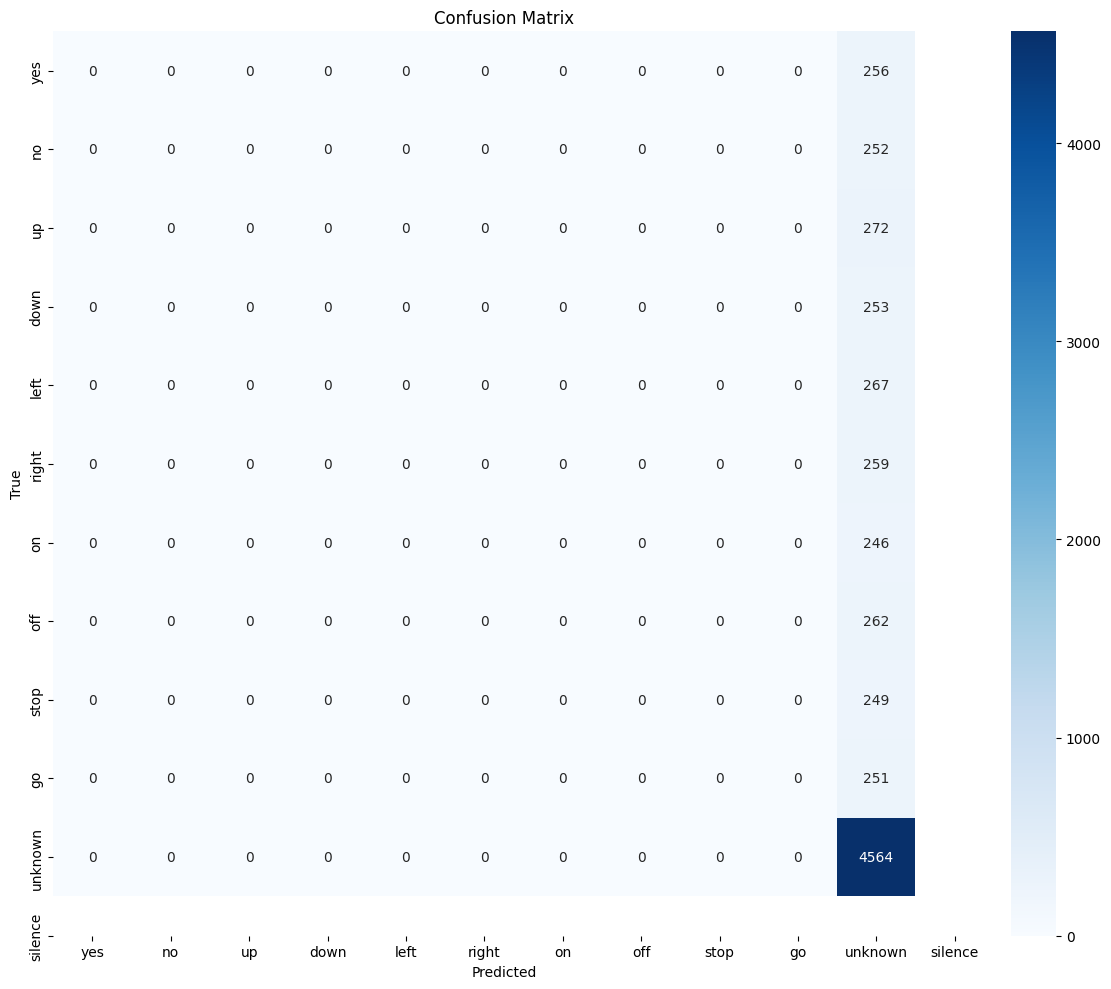

ValueError: Number of classes, 11, does not match size of target_names, 12. Try specifying the labels parameter

In [12]:
# # 1. Load the model from checkpoint
# checkpoint_path = "../../results/wav2vec/checkpoint-500"  # Update this to your actual checkpoint path

# # Load model from checkpoint
# model = Wav2Vec2ForSequenceClassification.from_pretrained(checkpoint_path)
# model = model.to(device)

# training_args.eval_strategy = "no"
# # 2. Initialize trainer with the loaded model
# trainer = Trainer(
#     model=model,
#     args=training_args,
#     compute_metrics=compute_metrics,
# )

# 3. Evaluate on test dataset
print("Evaluating model on test dataset...")
eval_results = trainer.evaluate(test_dataset)
print(f"Test accuracy: {eval_results['eval_accuracy']:.4f}")

# 4. Get detailed predictions for further analysis
predictions = trainer.predict(test_dataset)
pred_labels = np.argmax(predictions.predictions, axis=1)
true_labels = predictions.label_ids

# 5. Compute confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=[test_dataset.index_to_label[i] for i in range(len(test_dataset.index_to_label))],
            yticklabels=[test_dataset.index_to_label[i] for i in range(len(test_dataset.index_to_label))])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# 6. Print classification report
print(classification_report(true_labels, pred_labels, 
                          target_names=[test_dataset.index_to_label[i] for i in range(len(test_dataset.index_to_label))]))

## Save the Fine-tuned Model

Let's save our fine-tuned model for future use.

In [13]:
# Save model and feature extractor
model_save_path = "../../models/wav2vec/wav2vec_speech_commands_model"
model.save_pretrained(model_save_path)
if hasattr(train_dataset, 'feature_extractor'):
    train_dataset.feature_extractor.save_pretrained(model_save_path)

# Save label mapping
import json
with open(os.path.join(model_save_path, "label_mapping.json"), "w") as f:
    json.dump({
        "index_to_label": train_dataset.index_to_label,
        "label_to_index": train_dataset.label_to_index
    }, f)

print(f"Model saved to {model_save_path}")

Model saved to ../../models/wav2vec/wav2vec_speech_commands_model


## Test the Model on New Audio

Let's test our fine-tuned model on a few examples from the test set.

In [ ]:
def predict_command(audio_path, model, feature_extractor, index_to_label):
    # Load audio with soundfile
    waveform, sample_rate = sf.read(audio_path)
    # Convert to mono if stereo
    if len(waveform.shape) > 1:
        waveform = np.mean(waveform, axis=1)
    
    # Resample to 16kHz if needed
    if sample_rate != 16000:
        # Using simple interpolation for resampling
        original_length = len(waveform)
        target_length = int(original_length * 16000 / sample_rate)
        indices = np.linspace(0, original_length - 1, target_length)
        waveform = np.interp(indices, np.arange(original_length), waveform)
        sample_rate = 16000
    
    # Process audio
    inputs = feature_extractor(
        waveform, 
        sampling_rate=16000,
        return_tensors="pt",
        padding=True
    )
    
    # Move inputs to the same device as model
    inputs = {k: v.to(model.device) for k, v in inputs.items()}
    
    # Get prediction
    with torch.no_grad():
        outputs = model(**inputs)
        predicted_id = torch.argmax(outputs.logits, dim=1).item()
        predicted_command = index_to_label[predicted_id]
    
    # Visualize
    plt.figure(figsize=(10, 4))
    plt.plot(np.linspace(0, len(waveform)/sample_rate, len(waveform)), waveform)
    plt.title(f'Predicted: {predicted_command}')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.tight_layout()
    plt.show()
    
    return Audio(data=waveform, rate=sample_rate), predicted_command

# Get the feature extractor
feature_extractor = train_dataset.feature_extractor if hasattr(train_dataset, 'feature_extractor') else None
if feature_extractor is None:
    feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("facebook/wav2vec2-base-960h")

# Test on a few random samples from the test set
for i in range(5):
    idx = np.random.randint(0, len(test_dataset))
    file_path = test_dataset.file_list[idx]
    sample = test_dataset[idx]
    true_label = test_dataset.index_to_label[sample["label"]]
    
    print(f"\nSample {i+1}: {os.path.basename(file_path)}")
    print(f"True label: {true_label}")
    
    audio_player, predicted = predict_command(
        file_path, model, feature_extractor, test_dataset.index_to_label
    )
    print(f"Predicted: {predicted}")
    display(audio_player)

## Conclusion

In this notebook, we've successfully:

1. Loaded and explored the TensorFlow Speech Recognition Challenge dataset
2. Created a custom dataset for Wav2Vec fine-tuning
3. Fine-tuned a pre-trained wav2vec model for speech command classification
4. Evaluated the model's performance
5. Tested the model on new audio samples

The fine-tuned model can now be used to classify speech commands with good accuracy. For further improvements, you could:

- Use data augmentation (time stretching, pitch shifting, adding noise)
- Try different wav2vec model variants
- Experiment with different hyperparameters
- Expand to more command categories

## Debug Problematic Audio Files

Since consistently experiencing errors during batch 675, it's likely that specific audio files are causing the issue. Let's identify and handle problematic files.

In [10]:
# Debug function to check for problematic audio files
def check_audio_files(dataset, batch_size=8):
    print("Checking for problematic audio files...")
    
    # Calculate which batch contains the problematic files
    problematic_batch = 0
    start_idx = (problematic_batch - 1) * batch_size
    end_idx = min(start_idx + batch_size * 10, len(dataset))  # Check this batch and the next one
    
    print(f"Examining files from index {start_idx} to {end_idx}")
    
    problematic_files = []
    
    for i in range(start_idx, end_idx):
        if i >= len(dataset):
            break
            
        try:
            file_path = dataset.file_list[i] if hasattr(dataset, 'file_list') else f"File at index {i}"
            print(f"Checking file {i}: {file_path}")
            
            # Try to load the file and process it
            sample = dataset[i]
            
            # If we have a waveform, check for NaN or infinity values
            if hasattr(sample, 'input_values') and isinstance(sample['input_values'], np.ndarray):
                waveform = sample['input_values']
                if np.isnan(waveform).any() or np.isinf(waveform).any():
                    print(f"  ⚠️ Warning: File contains NaN or Inf values: {file_path}")
                    problematic_files.append((i, file_path, "NaN or Inf values"))
                    continue
                    
                # Check for extremely large or small values
                if np.abs(waveform).max() > 100:
                    print(f"  ⚠️ Warning: File contains extreme values: {file_path}")
                    problematic_files.append((i, file_path, "Extreme values"))
                    continue
            
            # Check the original audio file
            if hasattr(dataset, 'file_list'):
                try:
                    waveform, sample_rate = sf.read(file_path)
                    duration = len(waveform) / sample_rate
                    print(f"  ✓ File OK: {duration:.2f}s, {sample_rate}Hz, shape={waveform.shape}")
                    
                    # Check for very short files
                    if duration < 0.1:  # Less than 100ms
                        print(f"  ⚠️ Warning: File too short ({duration:.3f}s): {file_path}")
                        problematic_files.append((i, file_path, "Too short"))
                    
                    # Check for silent files
                    if np.abs(waveform).max() < 0.001:
                        print(f"  ⚠️ Warning: File is silent: {file_path}")
                        problematic_files.append((i, file_path, "Silent"))
                        
                except Exception as e:
                    print(f"  ❌ Error loading file: {file_path}, Error: {str(e)}")
                    problematic_files.append((i, file_path, str(e)))
                    
        except Exception as e:
            print(f"  ❌ Error processing index {i}: {str(e)}")
            problematic_files.append((i, f"Index {i}", str(e)))
    
    print(f"\nFound {len(problematic_files)} problematic files")
    for idx, file, reason in problematic_files:
        print(f"  - Index {idx}: {file} - {reason}")
        
    return problematic_files

# Run the check on the training dataset
problematic_files = check_audio_files(train_dataset, batch_size=training_args.per_device_train_batch_size)

Checking for problematic audio files...
Examining files from index -8 to 72
Checking file -8: D:\Studia - Pobrane Wyklady\MINI\Semestr 8\Deep_Learning_Projects\Project_2\data\train\audio\zero\ffbb695d_nohash_1.wav
Waveform shape: (16000,), Sample rate: 16000
  ✓ File OK: 1.00s, 16000Hz, shape=(16000,)
Checking file -7: D:\Studia - Pobrane Wyklady\MINI\Semestr 8\Deep_Learning_Projects\Project_2\data\train\audio\zero\ffbb695d_nohash_2.wav
Waveform shape: (16000,), Sample rate: 16000
  ✓ File OK: 1.00s, 16000Hz, shape=(16000,)
Checking file -6: D:\Studia - Pobrane Wyklady\MINI\Semestr 8\Deep_Learning_Projects\Project_2\data\train\audio\zero\ffd2ba2f_nohash_0.wav
Waveform shape: (16000,), Sample rate: 16000
  ✓ File OK: 1.00s, 16000Hz, shape=(16000,)
Checking file -5: D:\Studia - Pobrane Wyklady\MINI\Semestr 8\Deep_Learning_Projects\Project_2\data\train\audio\zero\ffd2ba2f_nohash_1.wav
Waveform shape: (16000,), Sample rate: 16000
  ✓ File OK: 1.00s, 16000Hz, shape=(16000,)
Checking file -4

## Additional Error Handling for Training

In [ ]:
# Let's implement a more robust training approach that can skip problematic batches if they occur.
# Custom training function with error handling for problematic batches
def train_with_error_handling(trainer, max_retries=3):
    # Keep track of the last successful step
    last_successful_step = 0
    retry_count = 0
    
    # Enable error handling in training args
    original_disable_tqdm = trainer.args.disable_tqdm
    trainer.args.disable_tqdm = False  # Enable progress bar to monitor progress
    
    print("Starting training with error handling...")
    try:
        trainer.train()
        print("Training completed successfully!")
        return True
    except Exception as e:
        print(f"\n\nError during training at step {trainer.state.global_step}: {str(e)}")
        print("Trying to recover...")
        
        # Save the current model checkpoint
        print(f"Saving checkpoint at step {trainer.state.global_step}")
        trainer.save_model(f"checkpoint-error-step-{trainer.state.global_step}")
        
        # Try to continue training by skipping the problematic batch
        print("Trying to continue training from the next batch...")
        train_dataloader = trainer.get_train_dataloader()
        
        # Calculate how many batches to skip
        if hasattr(train_dataloader, "sampler") and hasattr(train_dataloader.sampler, "set_epoch"):
            # If we're using a sampler that can be reset, try to advance it
            print("Advancing data sampler...")
            current_epoch = trainer.state.epoch
            train_dataloader.sampler.set_epoch(int(current_epoch) + 1)
        
        # Restart training
        print("Restarting training...")
        try:
            trainer.train()
            print("Training successfully recovered!")
            return True
        except Exception as e2:
            print(f"Failed to recover training: {str(e2)}")
            return False
    finally:
        # Restore original settings
        trainer.args.disable_tqdm = original_disable_tqdm

# Use this function instead of calling trainer.train() directly
# We'll use it in the training cell